### Описание задачи

Необходимо выявлить определяющие факторы успешности игры для оперделения потенциально популярного продукта и планирования рекламных компаний на основе данных до 2016 года (2016 год - неполный)

#### Данные

Данные представлены в одном файле с детализацией на:

* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* Продажи по регионам в миллионах проданных копий в Северной Америке (NA_sales), Европе (EU_sales), Японии (JP_sales) и других стран (Other_sales)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию: «Для взрослых», «Для детей младшего возраста» или «Для подростков».

### Оглавление

* [Изучение и предобработка файлов](#1-bullet)
* [Исследовательский анализ данных](#2-bullet)
* [Портрет пользователя каждого региона](#3-bullet)
* [Проверка гипотез](#4-bullet)
* [Общий вывод](#5-bullet)

### 1. Изучение и предобработка файлов. <a class="anchor" id="1-bullet"></a>

Подключение бибилотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

Открытие файла 

In [2]:
data_games = pd.read_csv('/datasets/games.csv', sep=',')
display(data_games.info())
display(data_games.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Переведем название колонок в нижний регистр для удобства и унификации

In [3]:
data_games.columns = data_games.columns.str.lower()

В данных есть пропуски. Из 16 715 строк пропущенных строк:
* 2 строки с названием имени
* 269 строк с годом выпуска (1,6%)
* 2 строки с жанром
* 8 578 с оценкой критиков (51,3%)
* 6 791 с оценкой пользователей (40,6%)
* 6 766 с рейтингом (40,5%)

Посмотрим пропуски в имени игр

In [4]:
display(data_games[data_games['name'].isnull()].head(5)) 

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Строки с пропусками в названии игры почти не содержат другой полезной информации (жанр, оценки пользователей, критиков и рейтинг). Пропуски в рейтинге скорее всего связаны с возрастом выпуска игры - 1993 год, а пропуск в названии - ошибка выгрузки, так как есть данные по выручке, поэтому игры существуют. Можно удалить это 2 строки, так как они не содержат полезной иноформации для анализа, также 2 строки не сместят статистику по общей выборке. Также решится проблема с пропусками в жанре, так как это одинаковые строки с пропусками в названии.

In [5]:
data_games = data_games[data_games['name'].isnull() == False]
data_games.reset_index(inplace=True, drop = True)
#display(data_games.head(660)) 

Посмотрим пропуски в дате выпуска игры. 

In [6]:
display(data_games[data_games['year_of_release'].isnull()].head(10))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,tbd,E
677,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,1.51,0.61,0.00,0.21,78.0,6.6,E10+
718,Call of Duty 3,Wii,NaN,Shooter,1.17,0.84,0.00,0.23,69.0,6.7,T
804,Rock Band,Wii,NaN,Misc,1.33,0.56,0.00,0.20,80.0,6.3,T


Посмотрим, как пропуски распределены по жанрам. Если равномерно, то можно оставить пропуски, не исключать их.

Text(0, 0.5, '% пропущенных значений года выпуска')

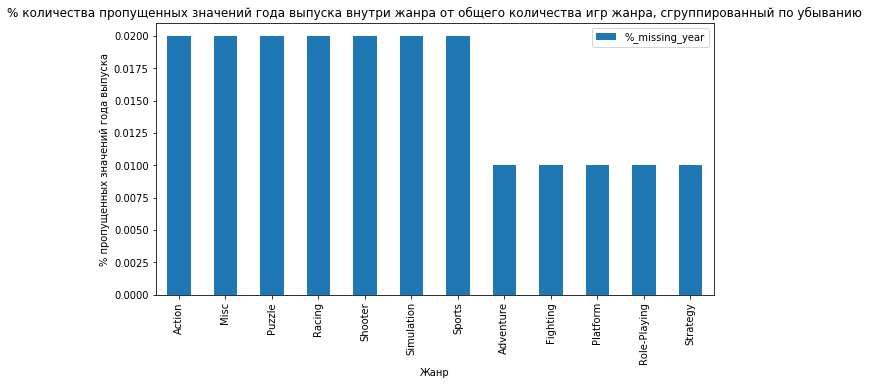

In [7]:
grouped_genre = pd.pivot_table(data_games, index = 'genre', values = ['name'], aggfunc = 'count' )
missing_year = pd.pivot_table(data_games[data_games['year_of_release'].isnull()], index = 'genre', values = 'name', aggfunc = 'count')
grouped_genre = grouped_genre.join(missing_year, how = 'outer', rsuffix = '_x')
grouped_genre.columns = ['total_number_games_in_genre', 'number_of_missing_years_in_genre']
grouped_genre ['%_missing_year'] = round(grouped_genre['number_of_missing_years_in_genre']/ grouped_genre['total_number_games_in_genre'],2)
grouped_genre.sort_values('%_missing_year', ascending = False)
missing_year_plot = grouped_genre.sort_values('%_missing_year', ascending = False).\
plot(title = '% количества пропущенных значений года выпуска внутри жанра от общего количества игр жанра, \
сгруппированный по убыванию',y= '%_missing_year', kind = 'bar',figsize = (10,5))
plt.xlabel('Жанр')
plt.ylabel('% пропущенных значений года выпуска')

* Пропуски с датой выхода составляют от 1% до 2% от общего количества игр внутри жанра. Нет сильных аномалий, поэтому можно оставить пропуски. Данные в строках с пропусками года выпуск можно дальше использовать для заполнения пропущенных оценок критиков и пользователей, поэтому не удаляем, а оставляем строки с пропусками даты выпуска. 
* Причина возникновения пропусков - отсутствие данных на сайтах, откуда бралась информация. Пропуски можно было бы заполнить, взяв даты выхода из Википедии или "спросить у Гугла"

#### Пропуски в оценках игр
* В столбце с оценкой пользователей есть значение tbd. Скорее всего это сокращение от to be determined (будет определено). Гипотеза в том, что для части игр (14.5%) рейтинг еще не определен из-за малого количества оценок.
* TBD заменяем на лучшее из возможных - оценку критиков, нормализованную к десятичной шкале

In [8]:
display(data_games.groupby('user_score')['user_score'].count())
data_games.query('user_score == "tbd"')
data_games.loc[data_games.query('user_score == "tbd"').index,'user_score'] = \
data_games.loc[data_games.query('user_score == "tbd"').index,'critic_score']/10
display(data_games.head(5))

user_score
0         1
0.2       2
0.3       2
0.5       2
0.6       2
       ... 
9.4      11
9.5       6
9.6       2
9.7       1
tbd    2424
Name: user_score, Length: 96, dtype: int64

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


* Переведем тип данных в столбце с пользовательской оценкой в вещественный формат для расчета медианы

In [9]:
data_games['user_score'] = pd.to_numeric(data_games['user_score'],errors = 'coerce', downcast = 'float')
data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         8672 non-null float32
rating             9949 non-null object
dtypes: float32(1), float64(6), object(4)
memory usage: 1.3+ MB


* В данных большое количество пропусков с оценками игр. Пропусков с оценкой критиков - 51%, с оценкой пользовователей - 41%.
* Гипотеза причины пропусков - 1. отсутствие данных в исходном источнике, 2. Для старых игр отсутствие самих рейтингов.

Для части игр есть оценки на одной платформе, но нет на другой. Гипотеза - оценки для одной и той же игры не сильно отличаются в зависимости от платформы. Поэтому можно заполнить часть пропусков медианными оценками игры на других платформах

In [10]:
# Список игр, сгруппированый по количеству использования на разных платформах
#display(data_games.groupby('name')['platform'].count().sort_values(ascending =False))

#Рейтинг для игры: Need for Speed: Most Wanted на PS3, PSV и WiiU можно заполнить медианным рейтингом между платформами
#display(data_games.query('name == "Need for Speed: Most Wanted"'))

#Сделаем сводную таблицу с медианной оценкой критиков и пользователей по каждой игре
multiplatform_games = pd.pivot_table(data_games, index = 'name',  values = ['critic_score','user_score'], aggfunc = 'median')

#Пропуски до заполнения
print ('Пропуски до заполнения')
display(data_games.info())

#Цикл для заполнения по имени игры
unique_games = data_games['name'].unique()
for game in unique_games:
    data_games.loc[(data_games['critic_score'].isnull()) & (data_games['name'] == game),'critic_score'] =\
    multiplatform_games.query('name == @game')['critic_score'].mean()
    data_games.loc[(data_games['user_score'].isnull()) & (data_games['name'] == game),'user_score'] =\
    multiplatform_games.query('name == @game')['user_score'].mean()
#Пропуски после заполнения    
print ('Пропуски после заполнения')
display(data_games.info())  

Пропуски до заполнения
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         8672 non-null float32
rating             9949 non-null object
dtypes: float32(1), float64(6), object(4)
memory usage: 1.3+ MB


None

Пропуски после заполнения
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       9098 non-null float64
user_score         9410 non-null float32
rating             9949 non-null object
dtypes: float32(1), float64(6), object(4)
memory usage: 1.3+ MB


None

* Количество пропущенных значений уменьшилось, но не сильно (оценка критиков на 961 строку, на 13%), (оценка пользователей на 738, на 9%), но зато с уверенностью можно сказать, что заполненные пропуски отражают действительность. 

#### Что делать с остальными пропусками в столбцах оценке критиков и оценке пользователей?
* Можно заполнить расчетными медианами, сгруппированными по жанру, платформе и может быть году. Гипотеза - в один и тот же год внутри одного жанра и платформы оценка критиков и пользователей не сильно отличается. Но заполнение более 40% данных сильно сместит распределение 
* Можно удалить сторки, но тогда потеряем более 40% данных
* Можно оставить пропуски, так мы оставим данные и сможем использовать столбцы выручки для аналитики выручки по годами

##### Решение: оставляем пропуски для того, чтобы выборка не сместилась и для того, чтобы максимально использовать имеющуюся информацию 

#### Пропуски в рейтинге игры

Рейтинг пропущен у 40% данных. Гипотеза - пропущенный рейтинг больше всего присущ старым играм, когда не было жесткого присуждения рейтинга игре. Проверим эту гипотезу: постром график по проценту игр с пропущенным рейтингом по годам

Text(0, 0.5, '% пропущенных значений года выпуска')

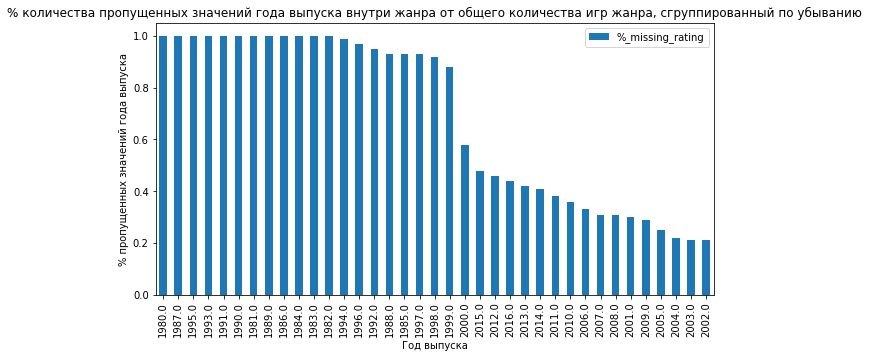

In [11]:
all_rating = pd.pivot_table(data_games, index = 'year_of_release', values = 'name', aggfunc = 'count' )
missing_rating = pd.pivot_table(data_games[data_games['rating'].isnull()], index = 'year_of_release',\
                                values = 'name', aggfunc = 'count')
all_rating = all_rating.join(missing_rating, how = 'outer', rsuffix = '_x')
all_rating.columns = ['total_number_games_in_year', 'number_of_missing_rating_in_year']

all_rating ['%_missing_rating'] = round(all_rating['number_of_missing_rating_in_year']\
                                        / all_rating['total_number_games_in_year'],2)
all_rating_plot = all_rating.sort_values('%_missing_rating', ascending = False).\
plot(title = '% количества пропущенных значений года выпуска внутри жанра от общего количества игр жанра, \
сгруппированный по убыванию',y= '%_missing_rating', kind = 'bar',figsize = (10,5))
plt.xlabel('Год выпуска')
plt.ylabel('% пропущенных значений года выпуска')

* Гипотеза подтверждается. До 1998 года почти у игр почти не было рейтингов (Entertainment Software Rating Board образовалась в 1994 году). В 1999 году процент игр без рейтинга сократился с 85 до 60, затем падал с каждый годом. 
* Исходя из этого оставим пропуски в данных до 1998 года точно. Пропуски в рейтинге для играх после 1998 года заполним так же, как для оценок пользователей и критиков. Часть игр выпускается на разных платформах: у одной и той же игры есть возрастной рейтинг на одной платформе, но нет на другой.

In [12]:
#Пример отсутсвтия возрастного рейтинга у одной и той же игры на разных платформах
display(data_games.query('name == "Need for Speed: Most Wanted"'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,82.0,8.5,NaN
1189,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1590,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1997,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2047,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,82.0,8.5,NaN
3580,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5971,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6272,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,82.0,8.5,NaN
6409,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


Сделаем сводную таблицу: строки - названия игр, столбец - рейтинг. Применяем функцию first, исходя из гипотезы, что у одной и той же игры одинаковый рейтинг на всех платформах.

In [13]:
#Сделаем сводную таблицу
age_rating_games = pd.pivot_table(data_games, index = 'name',  values = 'rating', aggfunc = 'first')
#Пропуски до заполнения
print ('Пропуски до заполнения')
display(data_games.info())

#Цикл для заполнения по имени игры
unique_games_missing_rating = data_games[data_games['rating'].isnull()]['name'].unique()
for game in unique_games_missing_rating:
    data_games.loc[data_games['name'] == game,'rating'] =\
    age_rating_games.query('name == @game')['rating']
#Пропуски после заполнения    
print ('Пропуски после заполнения')
display(data_games.info())  

Пропуски до заполнения
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       9098 non-null float64
user_score         9410 non-null float32
rating             9949 non-null object
dtypes: float32(1), float64(6), object(4)
memory usage: 1.3+ MB


None

Пропуски после заполнения
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       9098 non-null float64
user_score         9410 non-null float32
rating             9269 non-null object
dtypes: float32(1), float64(6), object(4)
memory usage: 1.3+ MB


None

Количество пропусков уменьшилось на 680 (10%). Оставшиеся пропуски оставим без изменения по причинам, аналогичным для пропусков оценок пользователей и критиков. 

Создадим столбец all_sales с общими продажами игр

In [14]:
data_games['all_sales'] = data_games['na_sales'] + data_games['eu_sales'] + data_games['jp_sales'] + data_games['other_sales']
data_games.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


#### Вывод

* Перевел название столбцов в нижний регистр.
* Удалил 2 строки без названия игр, жанра и оценок, так как данные не применимы для анализа, общая выборка не сместила при удалении. Причина возникновения пропусков - неправильный парсинг или отстутстив данных у источника, так как игры вышли в 1993 году (довольно старые)
* Оставил пропуски в годах выпуска так как количество пропусков не сильно зависит от жанра. Поэтому при оставлении пропусков, а не замене их на медианные или еще какие-ниюудь значения выборка не сильно сместится. Причина пропусков - отсуствие данных у источника. Можно было бы исправить, спарсив данные с Википедии
* В столбце с оценкой пользователей есть значение tbd. Скорее всего это сокращение от to be determined (будет определено). Гипотеза в том, что для части игр (14.5%) рейтинг еще не определен из-за малого количества оценок. Заменил часть пропусков на оценку критиков, нормализованную к десятичной шкале. Перевел тип данных из пользовательских оценок в вещественный формат.
* В данных большое количество пропусков с оценками игр. Пропусков с оценкой критиков - 51%, с оценкой пользовователей - 41%. Гипотеза причины пропусков - 1. отсутствие данных в исходном источнике, 2. Для старых игр отсутствие самих рейтингов.
* Для части игр есть оценки на одной платформе, но нет на другой. Гипотеза - оценки для одной и той же игры не сильно отличаются в зависимости от платформы. Запонил часть пропусков медианными оценками игры на других платформах. Количество пропущенных значений не сильно уменьшилось (оценка критиков на 961 строку, на 13%), (оценка пользователей на 738, на 9%), но зато с уверенностью можно сказать, что заполненные пропуски отражают действительность.
* Оставшиеся пропуски в оценках игр оставляем для того, чтобы выборка не сместилась и для того, чтобы максимально использовать имеющуюся информацию.
* Рейтинг пропущен у 40% данных. Гипотеза - пропущенный рейтинг больше всего присущ старым играм, когда не было жесткого присуждения рейтинга игре. Проверим эту гипотезу: постром график по проценту игр с пропущенным рейтингом по годам. Гипотеза подтверждается: до 1999 года почти у всех игр не было рейтинга из-за того, что ESRB образовалась только в 1994 году. После 1999 году процент количества игр с пропуском рейтинга уменьшается из года в год.
* Заполнил часть пропусков в рейтинге аналогично заполнению пропусков в оценках польователей и критиков: часть игр выпускается на разных платформах, при этом у одной и той же игры есть возрастной рейтинг на одной платформе, но нет на другой (заполнил 10% пропусоков в рейтинге).  
* Оставшиеся пропуски в рейтинге оставил без изменения. 
* Создал столбец с общими продажами

### 2. Исследовательский анализ данных. <a class="anchor" id="2-bullet"></a>

* [2.1. Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?](#2_1-bullet)
* [2.2. Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?](#2_2-bullet)
* [2.3. Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
Не учитывайте в работе данные за предыдущие годы. Не учитывайте в работе данные за предыдущие годы.](#2_3-bullet)
* [2.4. Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.](#2_4-bullet)
* [2.5. Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.](#2_5-bullet)
* [2.6. Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы. Соотнесите выводы с продажами игр на других платформах.](#2_6-bullet)
* [2.7. Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?](#2_7-bullet)

Сделаем функцию для постройки гистаграмм

In [15]:
def hist(data, index_, values_, sort, funct, name, legend_, y_max, xlabel,ylabel):
    all_games = pd.pivot_table(data, index = index_, values = values_, aggfunc = funct)
    all_games_plot = all_games.sort_values(sort, ascending = True).\
    plot(title = name ,y= values_, kind = 'bar',figsize = (10,5),legend=legend_, ylim = (0, y_max))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

#### 2.1. Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды? <a class="anchor" id="2_1-bullet"></a>


Приведем год выпуска игры к целочисленному типу

In [16]:
data_games['year_of_release'] = data_games['year_of_release'].astype('Int64')

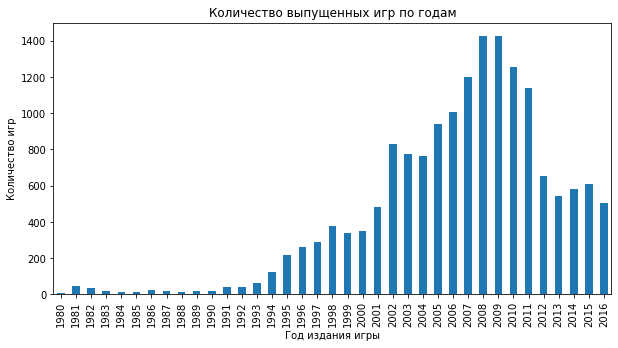

In [45]:
hist (data_games,'year_of_release','name', 'year_of_release','count','Количество выпущенных игр по годам', 0,1500,\
      'Год издания игры','Количество игр')

#### Вывод
* Количество игр резко возрасло после 2001 года, наблюдался рост выпуска количества игр до 2008 года, но затем идет спад. Возможная причина спада - кризис 2008 года. 
* В 2011 году количество игр относительно 2010 года сократилось в 2 раза (с 1200 до 600). После 2011 года количество выпускаемых игр примерно постоянно. Для дальнейшего анализа будем использовать данные с 2012 по 2016 года, так как не понятны причины падения количества игр. 

#### 2.2. Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы? <a class="anchor" id="2_2-bullet"></a>

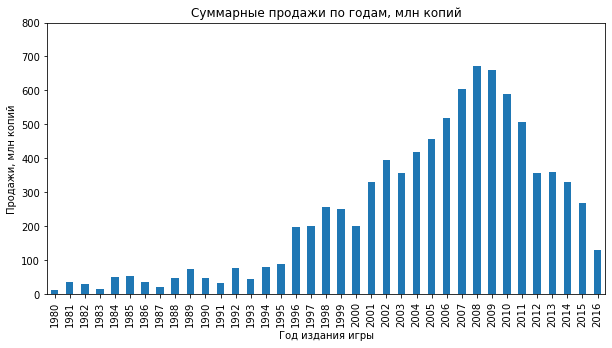

In [19]:
hist(data_games,'year_of_release','all_sales', 'year_of_release','sum','Суммарные продажи по годам, млн копий',0, 800,\
      'Год издания игры','Продажи, млн копий')

Рынок продаж игр падает не только по количеству выпускаемых игр, но и по количеству проданных копий с 2011 года. Снижение продаж в 2016 году объясняется тем, что данные за 2016 год неполные (год не закончился)

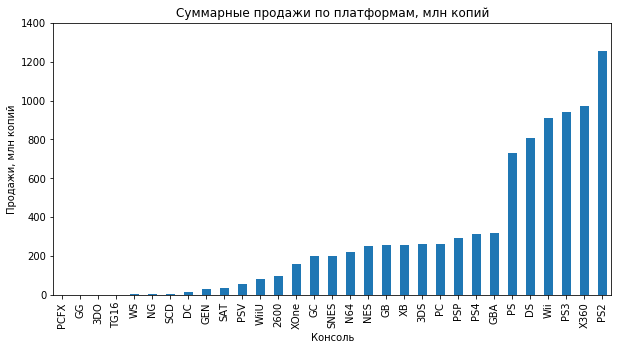

In [20]:
hist(data_games,'platform','all_sales', 'all_sales','sum','Суммарные продажи по платформам, млн копий',0, 1400,\
      'Консоль','Продажи, млн копий')

* Выделяется одна платформы - лидер по продажам: PS2 
* Следующая группа платформ - X360, PS3, Wii, DS, PS

Построим графики по продажам c разбивкой на годы для 6 лидеров платформ

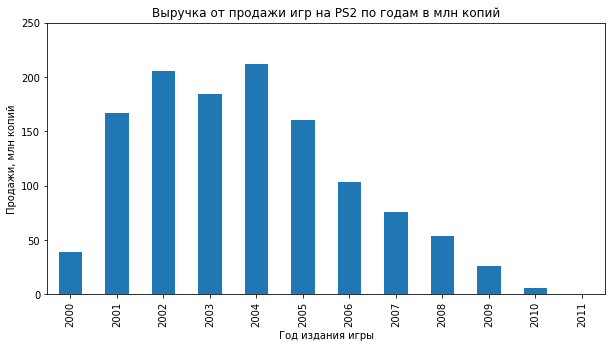

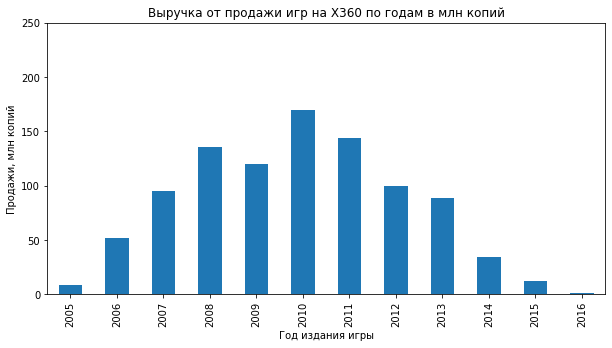

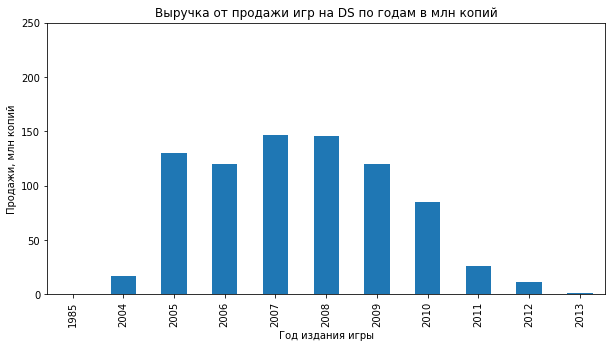

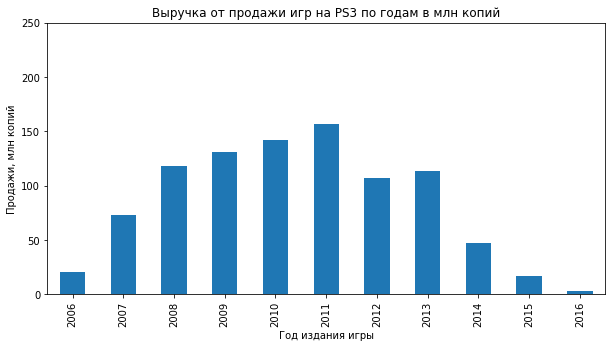

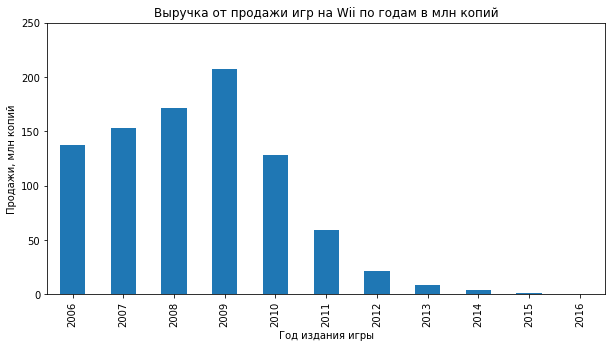

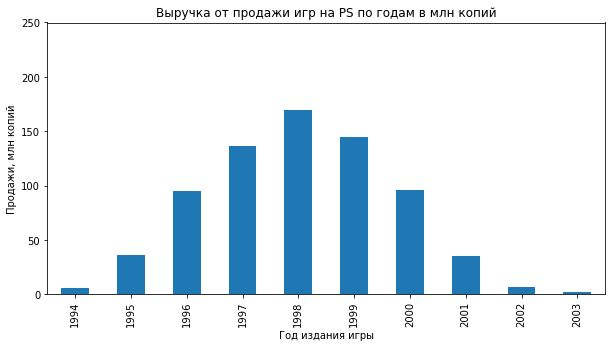

In [21]:
platform_list = ['PS2', 'X360','DS', 'PS3','Wii','PS']
for platform in platform_list:
    hist(data_games.query('platform == @platform'),'year_of_release','all_sales','year_of_release','sum',\
                      f'Выручка от продажи игр на {platform} по годам в млн копий',0,250,\
      'Год издания игры','Продажи, млн копий')


#### Вывод
* Лидер по суммарному количеству копий - PS2 не используется после 2011 года из-за выхода PS3. Срок существования платформы - 10 лет
* Пик второго лидера по количеству продаж X360 был в 2010 году. X360 также уже не используется, Xbox one заменила ее. Срок существования - 10 лет
* Срок существования отсальных лидирующий платформ - 7- 10 лет
* Стоит отметить, что в топ по продажам не попали текущие платформы, так как пик продаж был в 2007-2011 году, когда новое поколение консолей еще не вышло
* Поэтому стоит расссматривать продажи на последние 3-5 с 2011, когда стали выходить новые консоли

#### 2.3. Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год. Не учитывайте в работе данные за предыдущие годы. Не учитывайте в работе данные за предыдущие годы. <a class="anchor" id="2_3-bullet"></a>

#### Вывод
Основываясь на пунктах 2.1 и 2.2., стоит взять актуальный период - последние 5 лет (2012-2016), так как на рынке с 2012 года вышло новое поколение консолей, с 2012 года стало выходить намного меньше игр, а также общее количество продаж сильно отличается от периода до 2012 года, включаем данные за 2016 год, несмотря на то что данные за 2016 не полные. Сделаем срез данных с 2012 года включительно по 2015 включительно

In [22]:
analysys_games = data_games.query('2017 > year_of_release >= 2012')

#### 2.4. Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ. <a class="anchor" id="2_4-bullet"></a>

Посмотрим платформы лидеры с 2012 года

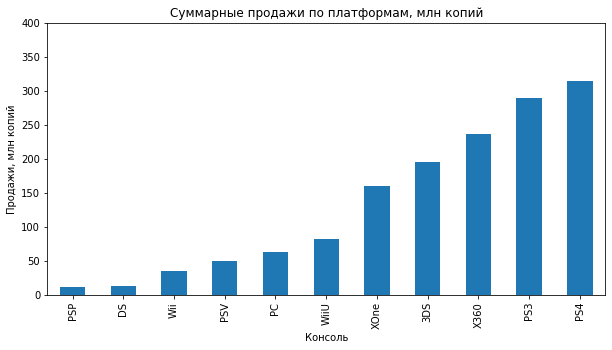

In [23]:
hist(analysys_games,'platform','all_sales', 'all_sales','sum','Суммарные продажи по платформам, млн копий',0, 400,\
      'Консоль','Продажи, млн копий')

В список для анализа попадут PS4, 3DS, XOne, WiiU. PS3 и X360 не попадут в список, так как их заменили новым поколением консолей

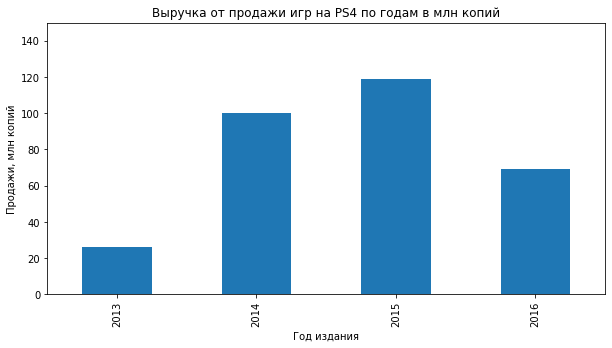

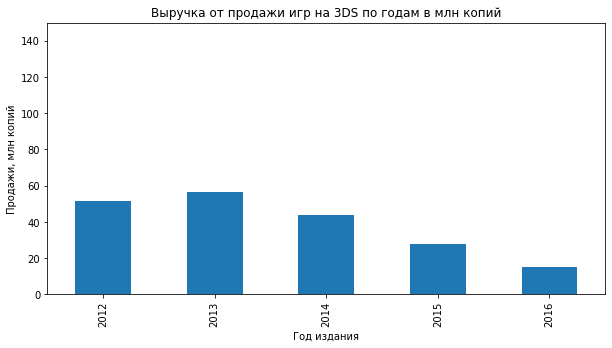

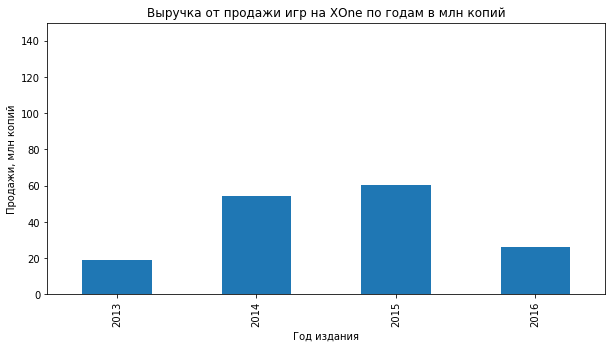

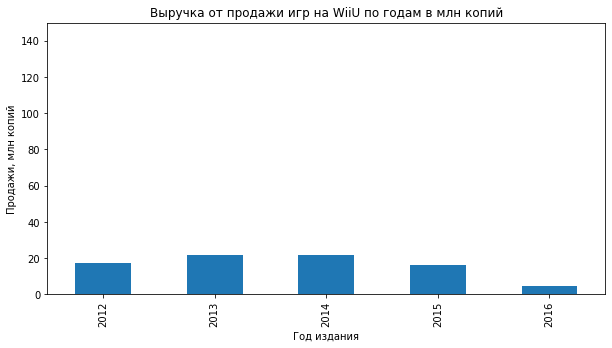

In [24]:
future_platforms = ['PS4', '3DS','XOne', 'WiiU']
for platform in future_platforms:
    hist(analysys_games.query('platform == @platform'),'year_of_release','all_sales','year_of_release','sum',\
                      f'Выручка от продажи игр на {platform} по годам в млн копий',0,150,\
      'Год издания','Продажи, млн копий')

#### Вывод
Из 4 текущих лидеров (PS4, XOne, 3DS, WiiU), растут продажи только у PS4 и XOne. Сделаем срез по этим платформам

In [25]:
future_platforms_games = analysys_games.query('platform == "PS4" or platform == "XOne"')

#### 2.5. Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат. <a class="anchor" id="2_5-bullet"></a>

Статистика для глобальных продаж 1 игры на PS4, млн копий


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


count    392.000000
mean       0.801378
std        1.609456
min        0.010000
25%        0.060000
50%        0.200000
75%        0.730000
max       14.630000
Name: all_sales, dtype: float64

Статистика для глобальных продаж 1 игры на XOne, млн копий


count    247.000000
mean       0.645020
std        1.036139
min        0.010000
25%        0.060000
50%        0.220000
75%        0.685000
max        7.390000
Name: all_sales, dtype: float64

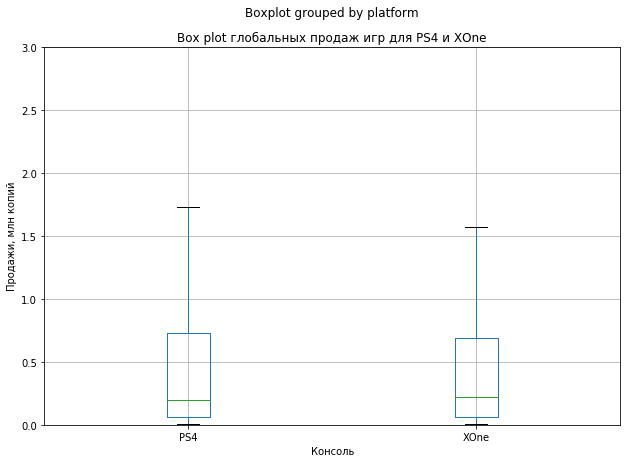

In [51]:
future_platforms_games.boxplot(column = 'all_sales', by = 'platform',showfliers = False, figsize = (10,7) )
plt.ylim(0, 3) 
plt.title('Box plot глобальных продаж игр для PS4 и XOne')
plt.xlabel('Консоль')
plt.ylabel('Продажи, млн копий')
print('Статистика для глобальных продаж 1 игры на PS4, млн копий')
display(future_platforms_games.query('platform == "PS4"')['all_sales'].describe())
print('Статистика для глобальных продаж 1 игры на XOne, млн копий')
display(future_platforms_games.query('platform == "XOne"')['all_sales'].describe())

#### Вывод
Статистика по IQR между платформами практически одинаковая, но немного лучшая для PS4 (больше медиана, среднее и квартили), основное различие в выбросах: выбросы на PS4 имеют в среднем большее количество продаж, чем на XOne. Это может свидетельствовать о большей популярности PS4 или о наличии популярных эксклюзивных игр на PS4

#### 2.6. Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы. Соотнесите выводы с продажами игр на других платформах. <a class="anchor" id="2_6-bullet"></a>

Для анализа возьмем самые перспективные платформы - PS4 и XOne

Сделаем фукцию для посторение граифика корреляции и расчета показателя корреляции

In [27]:
def correlation (data, title, y_value, x_value, parametr):
    data.plot(title = title, y=y_value, x=x_value, kind = 'scatter', figsize = (10,5))
    plt.xlabel(parametr)
    plt.ylabel('Продажи, млн копий')
    print(title,'равна',round(data[y_value].corr(data[x_value]),1)) 

Посмотрим на зависимости отзывов критиков и пользователей на продажи в разрезе PS4 и XOne

Функция для завимости внутри консоли

In [28]:
def platform_cor (data, name):
    correlation(data, f'Корреляция между отзывами критиков и продажами на {name}','all_sales', 'critic_score',\
                'Отзывы критиков (из 100)')
    correlation(data, f'Корреляция между отзывами пользователей и продажами на {name}','all_sales', 'user_score',\
                'Отзывы пользователей (из 10)')

Корреляция между отзывами критиков и продажами на PS4 равна 0.4
Корреляция между отзывами пользователей и продажами на PS4 равна -0.0
Корреляция между отзывами критиков и продажами на XOne равна 0.4
Корреляция между отзывами пользователей и продажами на XOne равна -0.0
Корреляция между отзывами критиков и продажами на всех платформах равна 0.3
Корреляция между отзывами пользователей и продажами на всех платформах равна 0.0


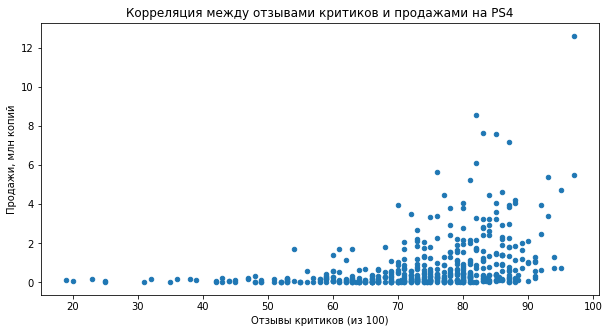

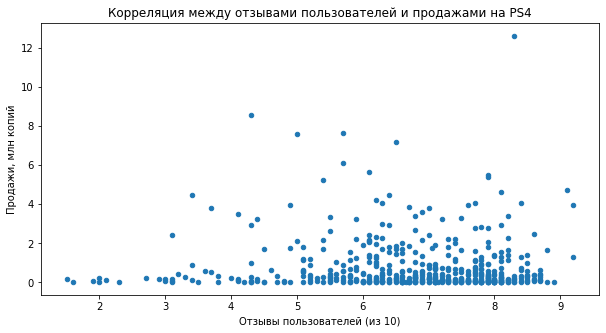

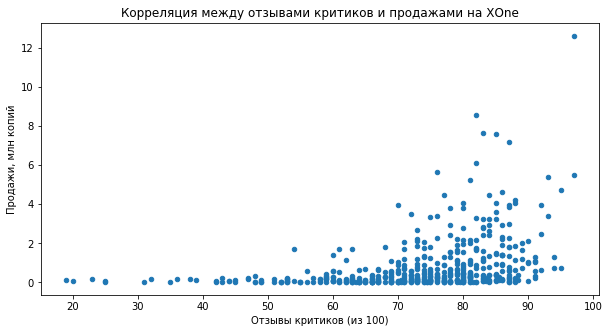

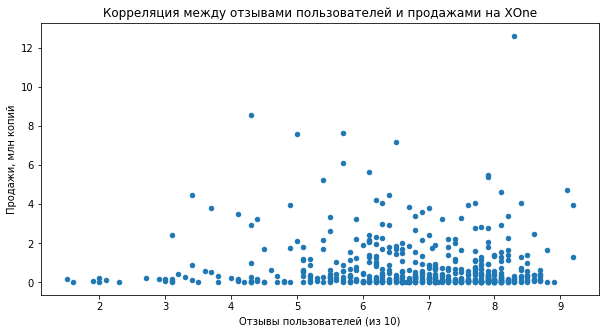

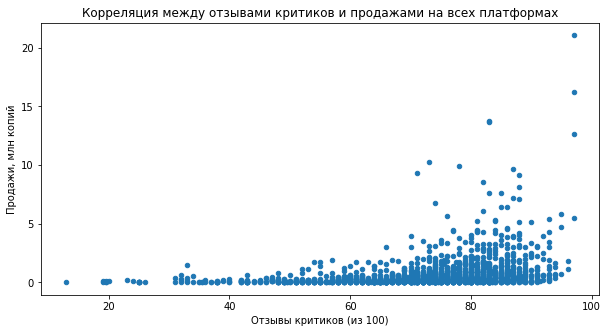

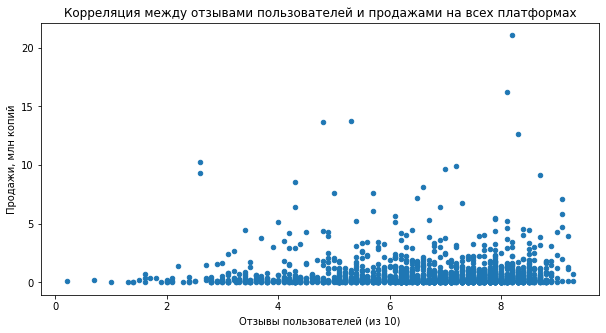

In [29]:
#PS4
platform_cor(future_platforms_games, 'PS4')
#XOne
platform_cor(future_platforms_games, 'XOne')
#Все платформы
platform_cor(analysys_games, 'всех платформах')

#### Вывод
* Существует слабая корреляция между продажами игр и отзывами критиков, тогда как корреляции между отзывами пользователей и продажами не наблюдается
* Такой вывод можно сделать не только по перспективным платформам, но и для всех платформ

#### 2.7. Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами? <a class="anchor" id="2_7-bullet"></a>

Сгруппируем игры по жанрам. Для анализа также возьмем 2 самые перспективные консоли

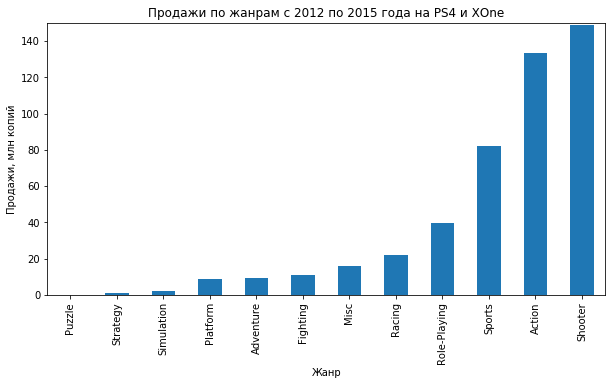

In [30]:
hist(future_platforms_games, 'genre','all_sales','all_sales','sum','Продажи по жанрам с 2012 по 2015 года на PS4 и XOne', 0,\
     150, 'Жанр', 'Продажи, млн копий')

* Продажи в жанрах Action и Shooter почти в два раза выше, чем в жанре Sports. Продажи в остальных жанарах более чем в 4 раза меньше, чем в Action и Shooter
* Самые непопулярные жанры - Puzzle, Strategy и Simulation

Теперь сделаем выборку по всем консолям с 2012 года. Сравним выводы с перспективными консолями

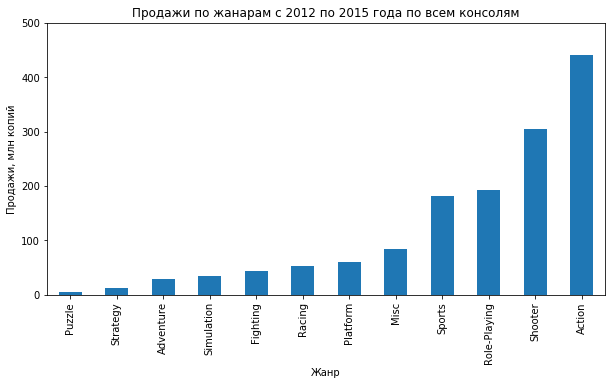

In [31]:
hist(analysys_games, 'genre','all_sales','all_sales','sum','Продажи по жанарам с 2012 по 2015 года по всем консолям', 0,\
     500, 'Жанр', 'Продажи, млн копий')

### <font color=purple>Исправления</font>
Посмотрим на распределение количества игр по жанрам для PS4 и XOne

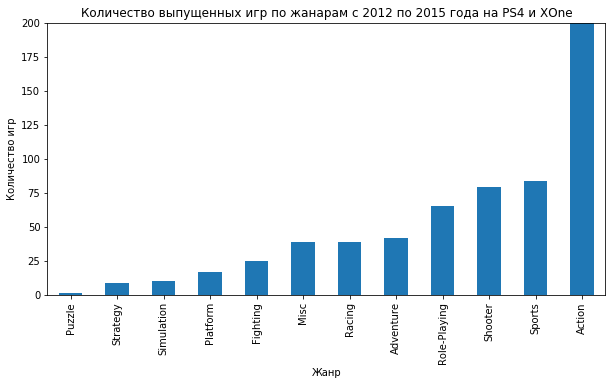

In [32]:
hist(future_platforms_games, 'genre','name','name','count',\
     'Количество выпущенных игр по жанарам с 2012 по 2015 года на PS4 и XOne',\
     0, 200, 'Жанр', 'Количество игр')

Теперь для всех консолей

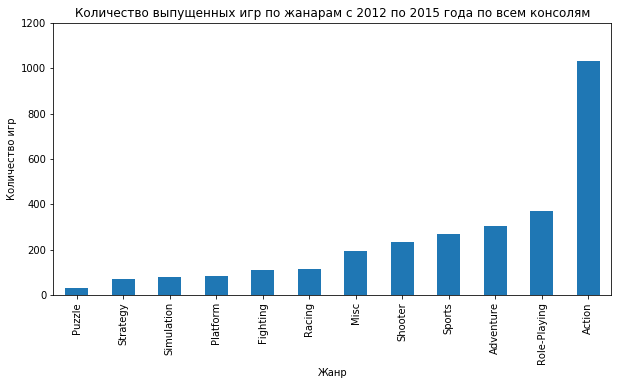

In [33]:
hist(analysys_games, 'genre','name','name','count',\
     'Количество выпущенных игр по жанарам с 2012 по 2015 года по всем консолям',\
     0, 1200, 'Жанр', 'Количество игр')

#### Вывод
* Для перспективных консолей (PS4 и XOne) лидируют жанры Action, Shooter и Sports по количеству продаж с 2012 года
* Если брать продажи по всем консолям с 2012 года, то в лидерах по прежнему Action, Shooter, Sports, но также есть Role-Playing 
* Для PS4 и XOne выручка от жанра Shooter и Action одинаковая, тогда как количество игр в жанре Shooter в 3 раза меньше. Это говорит о том, что в сегменте Shooter больше блокбастеров, чем в Action. Аналогичный вывод можно сделать из суммарных данных по всем патформам 

### 3. Портрет пользователя каждого региона. <a class="anchor" id="3-bullet"></a>

Определите для пользователя каждого региона (NA, EU, JP):
* Самые популярные платформы (топ-5). Опишите различия в долях продаж.
* Самые популярные жанры (топ-5). Поясните разницу.
* Влияет ли рейтинг ESRB на продажи в отдельном регионе?

#### Платформы

Посмотрим на продажи в каждом регионе. 

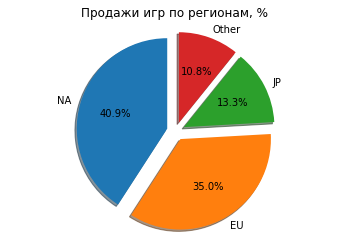

In [34]:
labels = 'NA', 'EU', 'JP', 'Other'
sizes = [analysys_games['na_sales'].sum(), \
             analysys_games['eu_sales'].sum(), \
             analysys_games['jp_sales'].sum(),\
         analysys_games['other_sales'].sum()]
explode = (0.1, 0.1, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal') 
plt.title('Продажи игр по регионам, %')
plt.show()

* 42% продаж приходится на Северную Америку и 35% на Европу
* Посмотрим на различия в долях по платформах

In [35]:
def pie_chart(platform):
    labels = 'NA', 'EU', 'JP', 'Other'
    sizes = [analysys_games.query('platform == @platform')['na_sales'].sum(), \
             analysys_games.query('platform == @platform')['eu_sales'].sum(), \
             analysys_games.query('platform == @platform')['jp_sales'].sum(),\
         analysys_games.query('platform == @platform')['other_sales'].sum()]
    explode = (0.1, 0.1, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
    plt.axis('equal') 
    plt.title(f'Продажи игр по регионам на платформе {platform}, % ')
    plt.show()

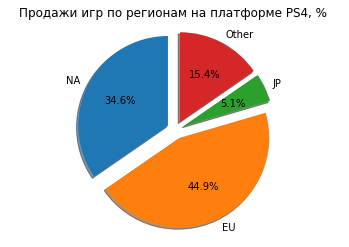

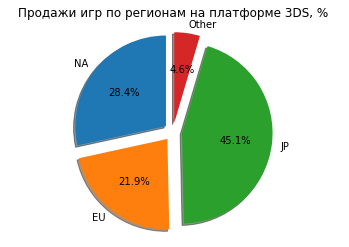

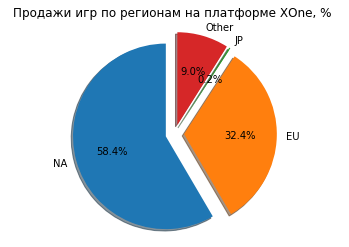

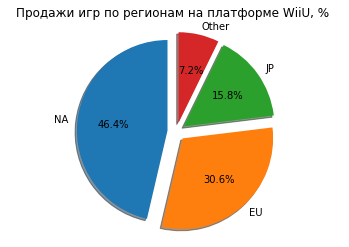

In [36]:
future_platforms = ['PS4', '3DS','XOne', 'WiiU']
for platform in future_platforms:
    pie_chart (platform)

* PS4 лучше всего продается в Европе, тогда как XOne и WiiU в Северной Америке, а 3DS в Японии
* Различия по регионам связаны со страной производителя платформы, а также с вложением средств в маркетинговые компании по регионам (PS4 - Южная Корея, целевой рынок Европа и Америка), XOne (США - целевой рынок Америка и Европа, вытесянет PS4 с Американского рынка за счет массовости маркетинга, WiiU - Япония, целевой рынок Япония, США, Европа, но не смогла конкурировать с 3DS в Японии), 3DS - Япония (целевой рынок Япония, Америка) 

#### Жанры

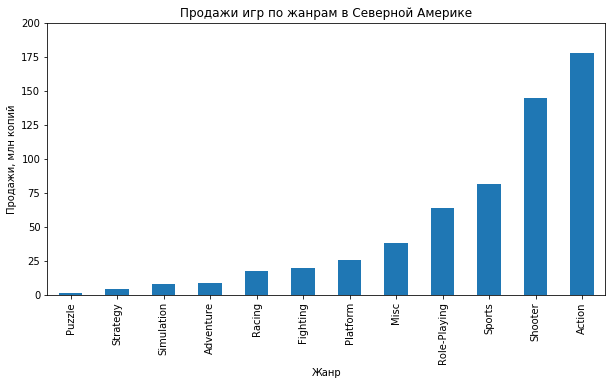

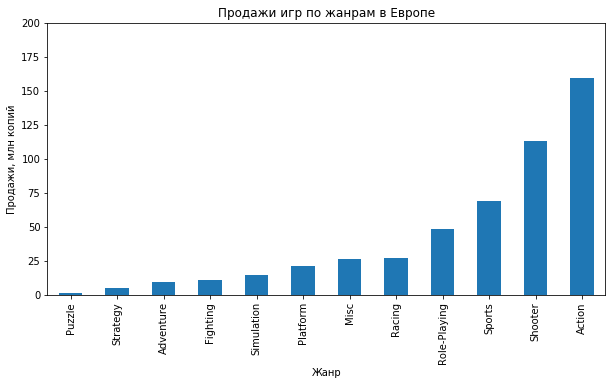

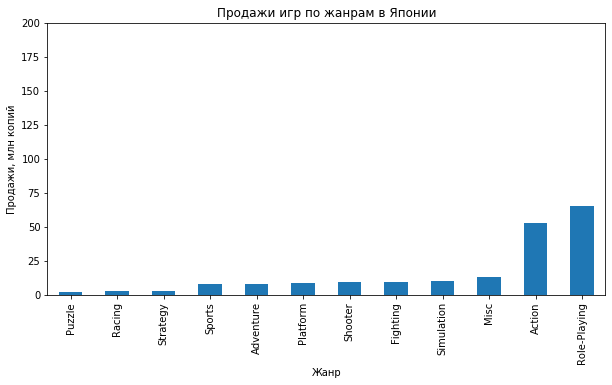

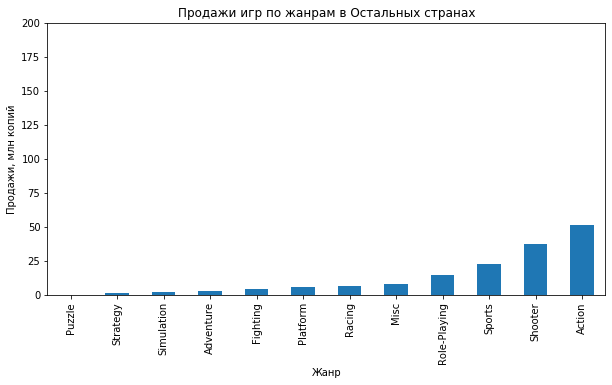

In [37]:
hist(analysys_games,'genre','na_sales','na_sales','sum',\
                     f'Продажи игр по жанрам в Северной Америке',0,200, 'Жанр', 'Продажи, млн копий')
hist(analysys_games,'genre','eu_sales','eu_sales','sum',\
                     f'Продажи игр по жанрам в Европе',0,200, 'Жанр', 'Продажи, млн копий')
hist(analysys_games,'genre','jp_sales','jp_sales','sum',\
                     f'Продажи игр по жанрам в Японии',0,200, 'Жанр', 'Продажи, млн копий')
hist(analysys_games,'genre','other_sales','other_sales','sum',\
                     f'Продажи игр по жанрам в Остальных странах',0,200, 'Жанр', 'Продажи, млн копий')

Во всех странах, кроме Японии популярны жанры Action, Shooter и Sports. В Японии в топ 3 входят Role-Playig, Action и Misc (Скорее всего опечатка, должно быть Music). Разницы в жанрах связаны с разницей в предпочтения жителей стран

#### Рейтинг ESRB

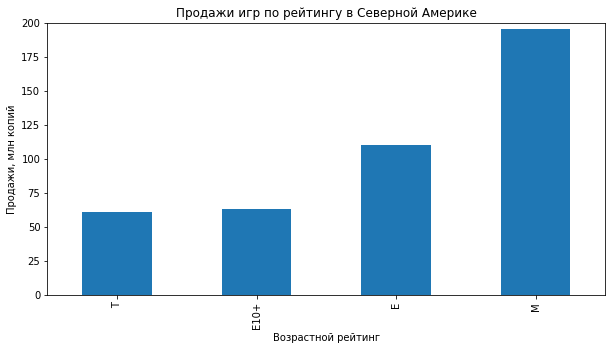

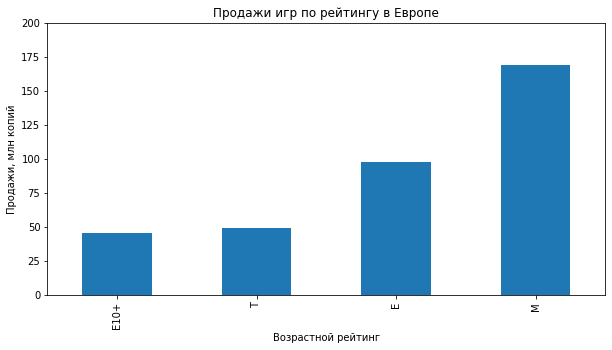

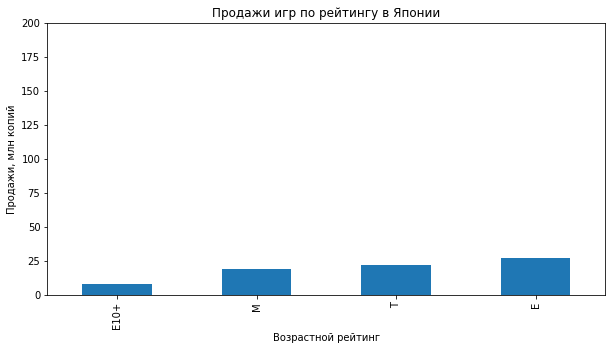

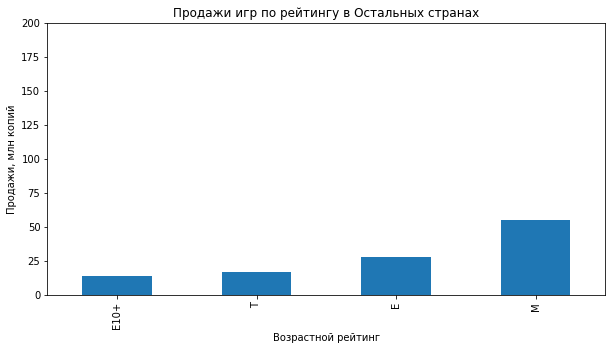

In [38]:
hist(analysys_games,'rating','na_sales','na_sales','sum',\
                     f'Продажи игр по рейтингу в Северной Америке',0,200, 'Возрастной рейтинг', 'Продажи, млн копий')
hist(analysys_games,'rating','eu_sales','eu_sales','sum',\
                     f'Продажи игр по рейтингу в Европе',0,200, 'Возрастной рейтинг', 'Продажи, млн копий')
hist(analysys_games,'rating','jp_sales','jp_sales','sum',\
                     f'Продажи игр по рейтингу в Японии',0,200, 'Возрастной рейтинг', 'Продажи, млн копий')
hist(analysys_games,'rating','other_sales','other_sales','sum',\
                     f'Продажи игр по рейтингу в Остальных странах',0,200, 'Возрастной рейтинг', 'Продажи, млн копий')

* Как всегда отличилась Япония ^_^
* В Европе, Америке наибольшей популярностью пользуются игры с рейтингов 17+ (M), затем без рейтинга (E -everyone), затем 10+ (E10+) и 13+ (T).
* В Японии предпочитают игры без рейтинга (это связано с тем, что популярные жанры - музыка role-playing), затем 13+, только потом 17+ и наконец 10+.
* В остальных странах первое место занимают также игры с рейтингом 17+
* Популярность игр с рейтингом 17+ объясняется популярностю жанров (Action, Shooter)

#### Вывод
* Продажи консоли зависят от страны производителя и региональных маркетинговых компаний
* Самые популярные жанры у всех, кроме Японии - Action, Shooter, Sports. В Японии Shooter и Sports заменяются Role-Playing и Music
* Возрастной рейтинг коррелирует с жанром, поэтому во всем мире, крое Японии популярен 17+ (Shooter), а в Японии (для всех - E)

### 4. Проверка гипотез. <a class="anchor" id="4-bullet"></a>

* [4.1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые](#4_1-bullet)
* [4.2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные](#4_2-bullet)

Функция для теста на равенство дисперсий

In [39]:
def equal_var (sample_1, sample_2):
    # Выберем 2 критических уровня 1% и 5%
    
    alpha_1 = 0.01
    alpha_2 = 0.05
    # Проведем тест на равенство дисперсии выборок
    # Нулевая гипотеза: дисперсии равны
    # Альтернативная гипотез: дисперсии отличаются
    
    test_variance = st.levene(sample_1, sample_2)
    display(test_variance)
    test_variance_pvalue = test_variance[1]
    if (test_variance_pvalue < alpha_1):
        print("Отвергаем нулевую гипотезу на уровне значимости", alpha_1)
    else:
        print("Не получилось отвергнуть нулевую гипотезу на уровне значимости",alpha_1)
    if (test_variance_pvalue < alpha_2):
        print("Отвергаем нулевую гипотезу на уровне значимости", alpha_2)
    else:
        print("Не получилось отвергнуть нулевую гипотезу на уровне значимости",alpha_2)    

Функция для t теста 

In [40]:
def t_test (sample_1, sample_2, var_parametr):
    # Выберем 2 критических уровня 1% и 5%
    
    alpha_1 = 0.01
    alpha_2 = 0.05
 
     # Проведем t-test
    test = st.ttest_ind(sample_1,sample_2, equal_var = var_parametr)
    # Расчитаем p-value
    print('p-значение:', test.pvalue)
    # Вывод
    if (test.pvalue < alpha_1):
        print("Отвергаем нулевую гипотезу на уровне значимости", alpha_1)
    else:
        print("Не получилось отвергнуть нулевую гипотезу на уровне значимости",alpha_1)
    if (test.pvalue < alpha_2):
        print("Отвергаем нулевую гипотезу на уровне значимости", alpha_2)
    else:
        print("Не получилось отвергнуть нулевую гипотезу на уровне значимости",alpha_2)   

#### Гипотеза 1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые <a class="anchor" id="4_1-bullet"></a>
* Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
* Альтернативная гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC различаются

In [41]:
#Определим сравниваемые выборки
xone_rating = data_games[data_games['user_score'].isnull() == False].query('platform == "XOne"')['user_score']
pc_rating = data_games[data_games['user_score'].isnull() == False].query('platform == "PC"')['user_score']
#Проведем тест на равенство дисперсий
equal_var (xone_rating, pc_rating)

LeveneResult(statistic=1.608258886321705, pvalue=0.2050324776461643)

Не получилось отвергнуть нулевую гипотезу на уровне значимости 0.01
Не получилось отвергнуть нулевую гипотезу на уровне значимости 0.05


Сильные подтверждения равенства дисперсий, поэтому проводим t-test с предпосылкой о равенстве

In [42]:
#Проведем t-test
t_test(xone_rating, pc_rating, 1)

p-значение: 0.00015911862804034112
Отвергаем нулевую гипотезу на уровне значимости 0.01
Отвергаем нулевую гипотезу на уровне значимости 0.05


Сильные подтверждения (на уровне значимости в 1%) для того,чтобы отвергнуть нулевую гипотезу о равенстве средних пользовательских рейтингов платформ Xbox One и PC.

#### Гипотеза 2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные. <a class="anchor" id="4_2-bullet"></a>
* Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports одинаковые
* Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports различаются

In [43]:
#Определим сравниваемые выборки
action_rating = data_games[data_games['user_score'].isnull() == False].query('genre == "Action"')['user_score']
sports_rating = data_games[data_games['user_score'].isnull() == False].query('genre == "Sports"')['user_score']
#Проведем тест на равенство дисперсий
equal_var (action_rating, sports_rating)

LeveneResult(statistic=14.185699825003224, pvalue=0.00016821869981336533)

Отвергаем нулевую гипотезу на уровне значимости 0.01
Отвергаем нулевую гипотезу на уровне значимости 0.05


Нет подтверждения равенства дисперсий, поэтому проводим t-test без предпосылки о равенстве

In [44]:
#Проведем t-test
t_test(action_rating, sports_rating, 0)

p-значение: 0.03404271180216309
Не получилось отвергнуть нулевую гипотезу на уровне значимости 0.01
Отвергаем нулевую гипотезу на уровне значимости 0.05


Существенные (на уровне значимости в 5%), но не сильные подтверждения для того,чтобы отвергнуть нулевую гипотезу о равенстве средних пользовательский рейтингов жанров Action и Sports.

#### Вывод

* Сильные подтверждения (на уровне значимости в 1%) для того,чтобы отвергнуть нулевую гипотезу о равенстве средних пользовательских рейтингов платформ Xbox One и PC.
* Существенные (на уровне значимости в 5%), но не сильные подтверждения для того,чтобы отвергнуть нулевую гипотезу о равенстве средних пользовательский рейтингов жанров Action и Sports.

### 5. Общий вывод. <a class="anchor" id="5-bullet"></a>

* Для запуска популярной игры стоит ориентироваться на 2 игровых приставки - PS4 и XOne, количество проданных копий немного выше для PS4
* Стоит обращать внимание на рейтинги критиков и прислышиваться к их мнению во время тестирования игры
* Самые популярные жанры - Shooter, Action и Sports
* Америка и Европа самые большие рынки, но стоит учитыать, что на этих рынка пользуется популярностью игры с рейтингом 17+ (учесть в разработке игры и изучить этот сегмент, если нацеливаться на наибольшие продажи)
* В сожалению в данных не было выручки в деньгах, так как большие продажи могут означать меньшую цену игры, поэтому чатсь выводом могут быть некорректны. Например, стоит определиться, какую цену назчнать на игру. Скорее всего будет несколько ценновых диапазонов, которые будут зависеть от жанра и региона